# Residual dynamics learning for Panda robot

In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
import joblib
import pybullet
from pbdlib import LQR
from pbdlib.utils import get_canonical
import pandapybullet as ppb
import torch
import time
import GPy, GPyOpt
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Gather training data 
### Define random sine reference

Run a LQR using desired joint position and velocity to retrieve jooitn acceleration

In [2]:
dt = 1e-3
world_sim = ppb.WorldSim()
world_sim.setup_scene()
world_sim.load_table()
robot = world_sim.load_panda()

In [3]:
N=10000
T = N*dt
n_training = 1
n_testing = 0
n_tot = n_training + n_testing
joint_limits = robot.joint_limits.copy()
joint_limits[1,:] = [-deg2rad(35),deg2rad(35)]
# joint_limits[3,0] = -deg2rad(60)

# Trajectories specifications
specs = {'phi': {'low': -np.pi, 'high': np.pi}, 
         'A': {'low': -np.pi, 'high': np.pi},
         'f': {'low': 1/20, 'high': .3},
         'nb_parts': 100, 'margin': .2, 'safety': .9}

pandaRobot, pandaRobot2 = Robot(7, 7, dt, N, robot), Robot(7, 7, dt, N, robot)
pandaRobot.drawTrajectories(nb_traj=n_tot, q_limits=joint_limits, specs=specs)
pandaRobot2.ref, pandaRobot2.desired_ddq = pandaRobot.ref, pandaRobot.desired_ddq
pandaRobot2.nb_traj = pandaRobot.nb_traj

## Gather training data using CTC + PD

### Tune PD controller

In [9]:
Kp = np.diag([50]*7)
Ki = np.eye(7)*5.
Kd = np.eye(7)*5.

robot.reset_q(max_iter=100)
robot.joints_free=True

joints are free now


### Perturb robot dynamics

In [18]:
rnd.seed(3)
P = rnd.uniform(.92,1.08,size=(7)) 
P = np.diag(P)
F_v = np.diag([.3,.3,.2,.2,.1,.05,.02])

In [5]:
def configuration_ctc(ddq, robot, P=np.eye(7)):
        """
            Configuration space computed torque control.

            Return:
                np.array (dof, ): the control input
        """
        return np.dot(np.multiply(
            robot.M,P), ddq) + robot.b + (
            1-int(robot._gravity_compensation))*robot.g + robot.damping@robot.dq

### Simulate using CTC + PD

In [19]:
log_control = np.empty(shape=[n_tot,7,N-1])
log_q = np.empty(shape=[n_tot,7,N])
log_dq = np.empty(shape=[n_tot,7,N])
log_ddq = np.empty(shape=[n_tot,7,N])

for n in range(n_tot):
    log_error = []
    sum_error = np.zeros(7)
    log_q[n,:,0] = robot.q
    log_dq[n,:,0] = robot.dq
    log_ddq[n,:,0] = robot.ddq
    
    robot.default_q = pandaRobot.ref[n,:7,0]
    robot.reset_q(max_iter=100)
    robot.joints_free=True
    for i in range(0, N-1):
        error_q = pandaRobot.ref[n,:7,i] - robot.q
        error_dq = pandaRobot.ref[n,7:,i] - robot.dq

    #   Computed Torque Control
        control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + pandaRobot.desired_ddq[n,:,i],
                                         robot)
        # Add viscous friction
        control_input -= F_v@robot.dq
    #     PID Control + Feedforward term (with inverse dynamics)
#         control_input = robot.inverse_dynamics(pandaRobot.desired_ddq[n,:,i]) + Kp @ error_q + Ki @ sum_error + Kd @ error_dq
#         control_input = Kp @ error_q + Ki @ sum_error + Kd @ error_dq
    
        for j in range(7):
            if control_input[j] < robot.joint_torque_limits[j,0]:
                control_input[j] = robot.joint_torque_limits[j,0].copy()
            if control_input[j] > robot.joint_torque_limits[j,1]:
                control_input[j] = robot.joint_torque_limits[j,1].copy()

        robot.set_torque(control_input[:7])

        log_error.append(np.copy(error_q))
        log_q[n,:,i] = robot.q.copy()
        log_dq[n,:,i] = robot.dq.copy()
        log_ddq[n,:,i] = robot.ddq.copy()
        log_control[n,:,i] = np.copy(control_input)
    #     time.sleep(dt)
        sum_error += error_q*dt
        
log_q[:,:,N-1] = log_q[:,:,N-2]
log_dq[:,:,N-1] = log_dq[:,:,N-2]

joints are free now


## Store data in state-space form

### Data for bad model (simulated)

In [11]:
pandaRobot.toStateSpace(log_q.copy(), log_dq.copy(), log_control.copy())

### Data for true dynamics (observed)

In [20]:
pandaRobot2.toStateSpace(log_q.copy(), log_dq.copy(), log_control.copy())

### Difference dynamics
Here, the difference between the data simulated with the bad model with the suitable controller and the data gathered using the same controller but on the true system dynamics (which have synthetically been altered) is computed. <br><br>
$$ \delta X = X_0 - X_{model}$$ <br><br>
After that, the same algorithm leveraging HAVOK will be employed to retrieve a dynamical expression of the dynamical discrepancy.

In [21]:
delta_U = pandaRobot2.U - pandaRobot.U
delta_X = pandaRobot2.X - pandaRobot.X

### Plot for bad model (but rightly calibrated controller)

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

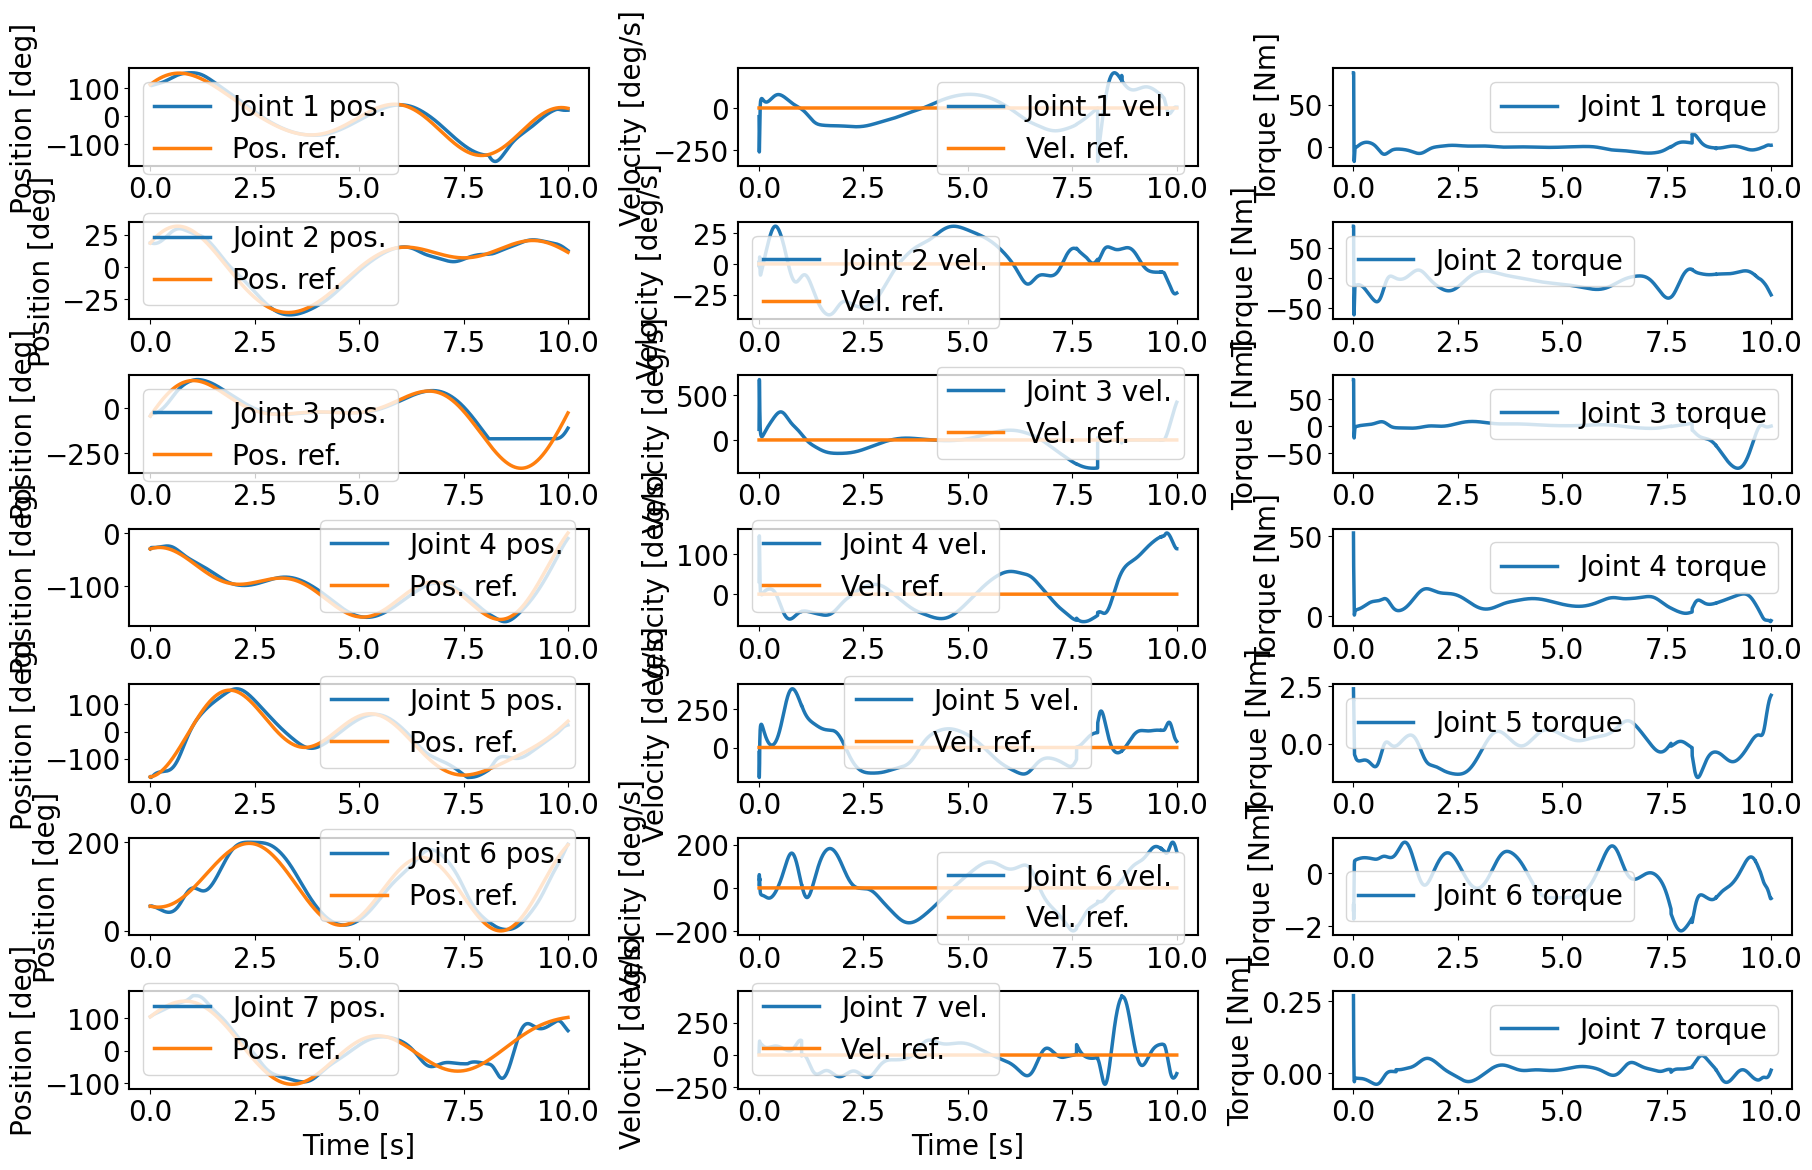

In [12]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.X[traj,i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.X[traj,i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], pandaRobot.U[traj,i,:], label='Joint '+str(i+1)+' torque')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Plot for true dynamics with wrong controller

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

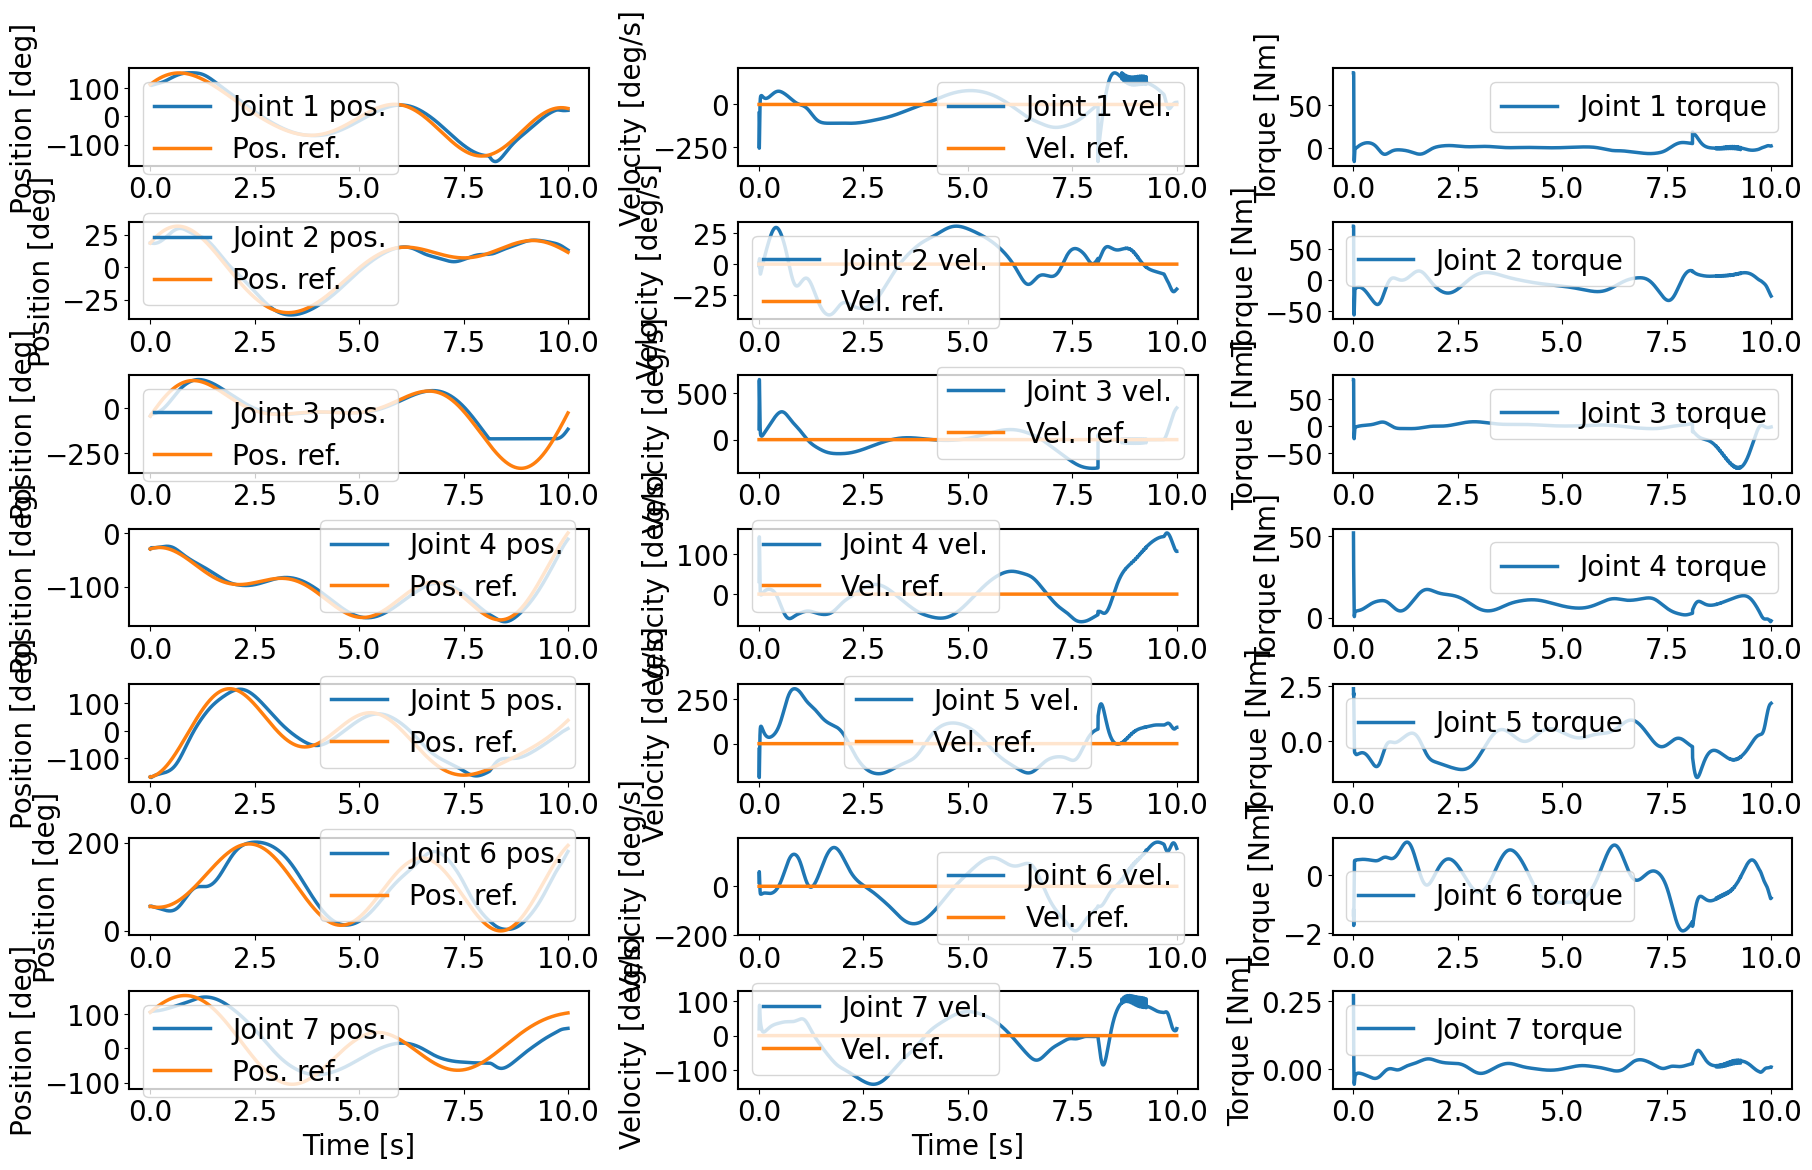

In [22]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(pandaRobot2.T, rad2deg(pandaRobot2.X[traj,i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot2.T, rad2deg(pandaRobot2.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot2.T, rad2deg(pandaRobot2.X[traj,i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot2.T, rad2deg(pandaRobot2.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot2.T[:len(pandaRobot2.T)-1], pandaRobot2.U[traj,i,:], label='Joint '+str(i+1)+' torque')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Plot residual dynamics

(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

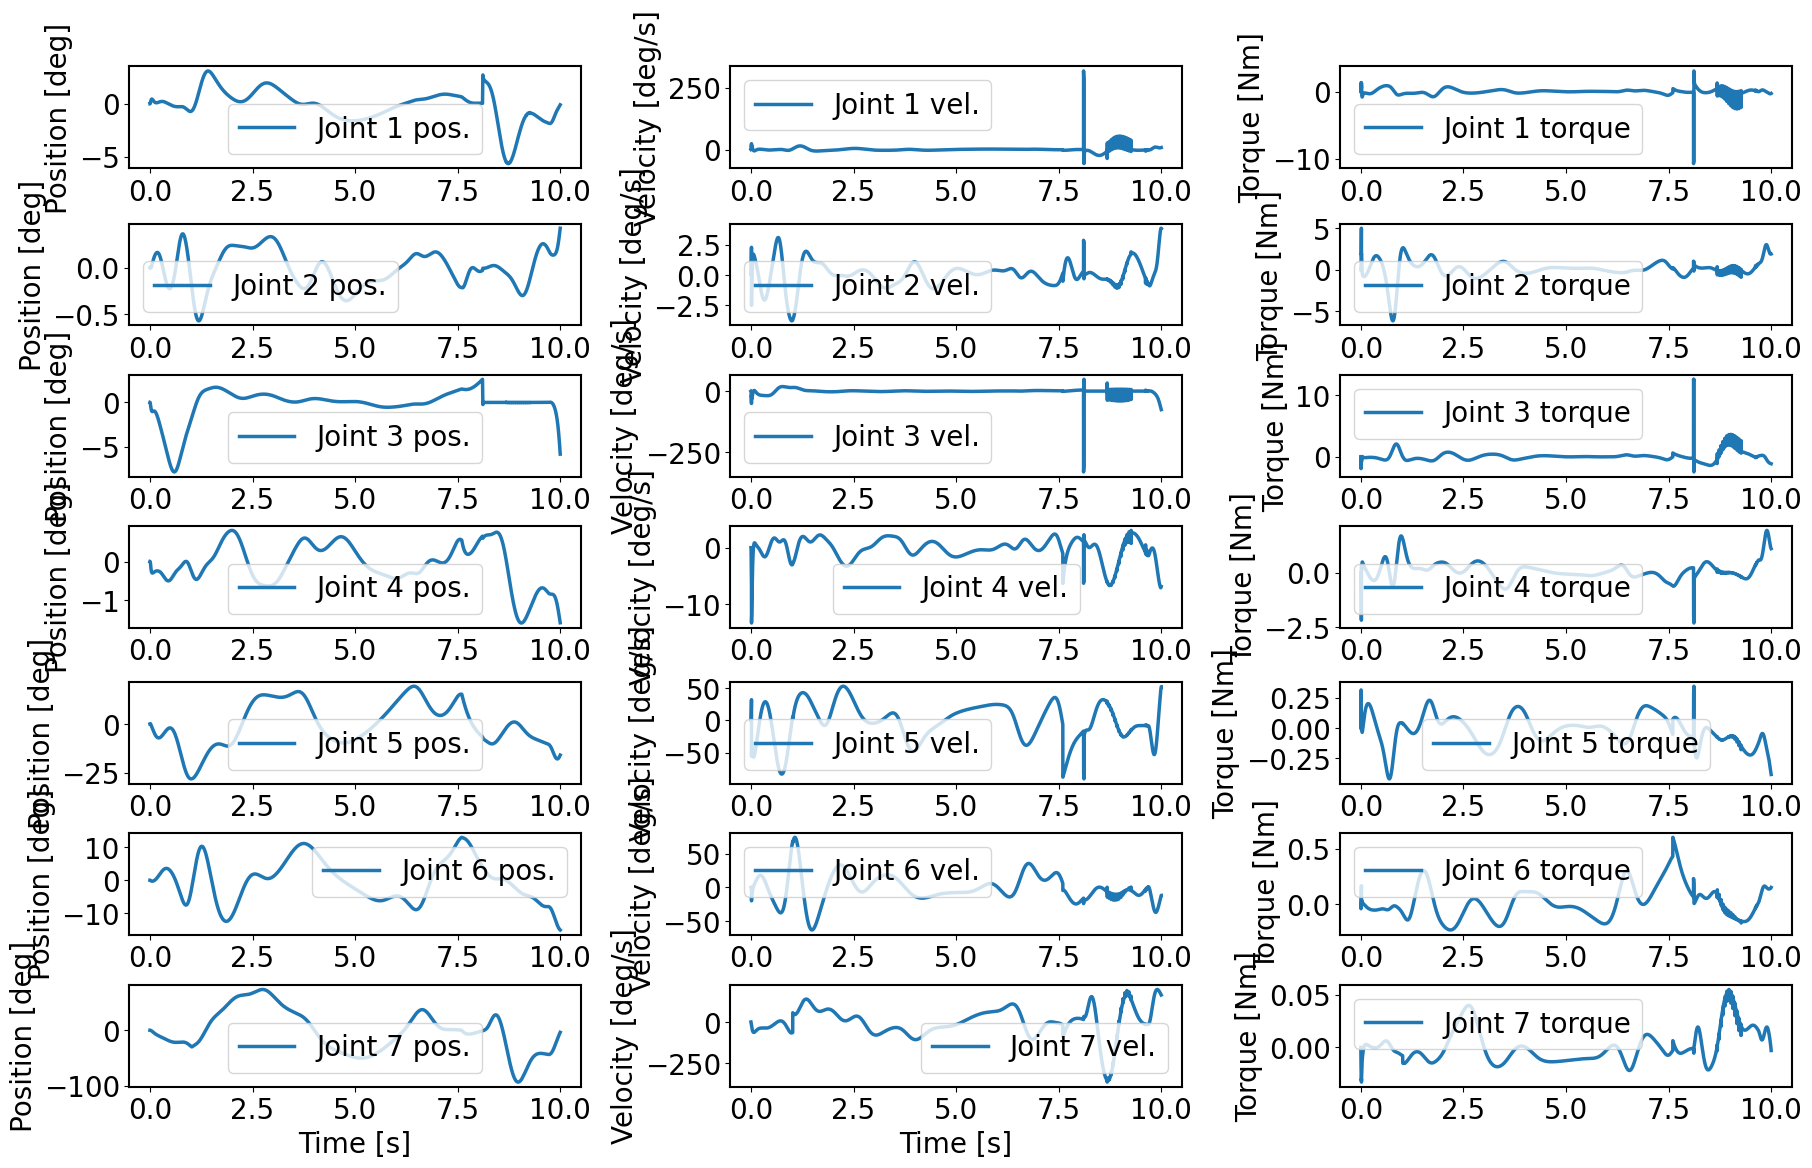

In [23]:
traj = 0
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,11))

for i in range(7):
    
    ax[i,0].plot(pandaRobot2.T, rad2deg(delta_X[traj,i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,1].plot(pandaRobot2.T, rad2deg(delta_X[traj,i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,2].plot(pandaRobot2.T[:-1], delta_U[traj,i,:], label='Joint '+str(i+1)+' torque')
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

## Model training 

### Using *GPyOpt*

In [91]:
traj_ratio = .02
n_low, n_high = 15, 120
d_low, d_high = 1, np.int((1-traj_ratio)/n_high*pandaRobot.N)
ref_zeros = np.zeros([14,pandaRobot.N-1])

domain = [
    {'name': 'input_cost', 'type': 'continuous', 'domain': (0.,3.)},
    {'name': 'dimension', 'type': 'discrete', 'domain': np.arange(1,30,1)},
    {'name': 'nb_traj', 'type': 'discrete', 'domain': np.arange(n_low,n_high,1)},
    {'name': 'nb_delays', 'type': 'discrete', 'domain': np.arange(d_low,d_high,1)}
]

print('delay max : ',np.int((1-traj_ratio)/n_high*pandaRobot.N))
print('points min : ',pandaRobot.N- d_high*n_high)

loss_traj = np.empty(shape=[n_training])
loss_U = np.empty(shape=[n_training])
loss_LQR = np.empty(shape=[n_training])

# @use_named_args(SPACE)
def loss(space):
    # Model parameters
    n_params = space.shape[0] # If train by batch
    u_std = space[0,0]
    s = np.int(space[0,1])
    n = np.int(space[0,2])
    d = np.int(space[0,3])
    
    timing = np.empty([2,n_training])
    
    for fold in range(n_training):
        timing[0,fold] = time.time() # HAVOK computation time
        
        model = HAVOK(delta_X[fold,:,:-1], pandaRobot.U[fold,:,:])
#         model = HAVOK(pandaRobot.X[fold,:,:], pandaRobot.U[fold,:,:])
        model.HANKEL(n, d)
        model.SVD(s)
        model.LS(s,rcond=0)
#         model.Simulate(pandaRobot.ref[fold,:,0],U_testing = pandaRobot.U[fold,:]) # Learn on differences

        timing[0,fold] = time.time() - timing[0,fold]  
        timing[1,fold] = time.time() # LQR computation time
        
        # LQR loss
        model.ConstructLQR(x_std=np.concatenate((1e6*np.ones([7]),np.zeros([7]))),
                           u_std=u_std,
                           dt=dt,
                           ref=ref_zeros,
#                            disturbance=delta_U[fold,:,:].numpy())
                           disturbance=pandaRobot2.U[fold,:,:].numpy()) 
        model.LQR_simulate(X0=pandaRobot.ref[fold,:,0], disturbance=pandaRobot2.U[fold,:,:].numpy())
#         print(model.LQR_simulate(X0=pandaRobot.ref[fold,:,0], disturbance=pandaRobot2.U[fold,:,:].numpy()))
        
#         loss_traj[fold] = model.RMSE(X_pred=model.X_traj, X_true=pandaRobot.X[fold,:,:]) 
        loss_LQR[fold] = model.RMSE(X_pred=torch.tensor(model.LQR_X[:7,:],dtype=torch.float), 
                                    X_true=torch.tensor(ref_zeros[:7,:],dtype=torch.float), regulation=True)
        
        timing[1,fold] = time.time() - timing[1,fold]  
        
    loss_LQR_sum = loss_LQR.sum()/n_training
    loss = loss_LQR_sum 
    avg_time = [timing[0,:].sum()/n_training,timing[1,:].sum()/n_training]
    
    if np.isnan(loss) or np.isinf(loss):
        loss = 1e10
        
    print('Total loss : '+str(loss)+'Loss LQR : '+str(loss_LQR_sum)+
          ', u_std : '+str(u_std)+', s :'+str(s)+', n :'+str(n)+', d : '+str(d))
    print('Avg computation time for HAVOK : '+str(avg_time[0])+' [s], for LQR : '+str(avg_time[1])+' [s]')
    
    return loss

max_iter = 1000
batch_size = 6
num_cores = 6

opt = GPyOpt.methods.BayesianOptimization(f = loss,            # function to optimize       
                                          domain = domain,         # box-constraints of the problem
                                          acquisition_type ='LCB',       # LCB acquisition
                                          acquisition_weight = 0.5)     # Exploration exploitation
 

opt.run_optimization(max_iter)

delay max :  81
points min :  280
Total loss : 718948.9078125Loss LQR : 718948.9078125, u_std : 0.2696929121923165, s :15, n :57, d : 69
Avg computation time for HAVOK : 2.4654895782470705 [s], for LQR : 2.8562710285186768 [s]
Total loss : 629360.525Loss LQR : 629360.525, u_std : 1.2976612738952777, s :23, n :114, d : 8
Avg computation time for HAVOK : 11.288313674926759 [s], for LQR : 3.2122335910797117 [s]
Total loss : 5895.9156494140625Loss LQR : 5895.9156494140625, u_std : 0.20622036195350024, s :3, n :61, d : 61
Avg computation time for HAVOK : 2.601648235321045 [s], for LQR : 2.316658592224121 [s]
Total loss : 369204.6859375Loss LQR : 369204.6859375, u_std : 0.05515674832015893, s :19, n :117, d : 56
Avg computation time for HAVOK : 2.845094680786133 [s], for LQR : 3.110487461090088 [s]
Total loss : 179758.21640625Loss LQR : 179758.21640625, u_std : 2.800698392154545, s :6, n :83, d : 45
Avg computation time for HAVOK : 4.182414627075195 [s], for LQR : 2.316614866256714 [s]
Total

KeyboardInterrupt: 

## LQR control of the Panda robot
### Construct LQR planner

LQR RMSE : tensor(3.8655, dtype=torch.float64)


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

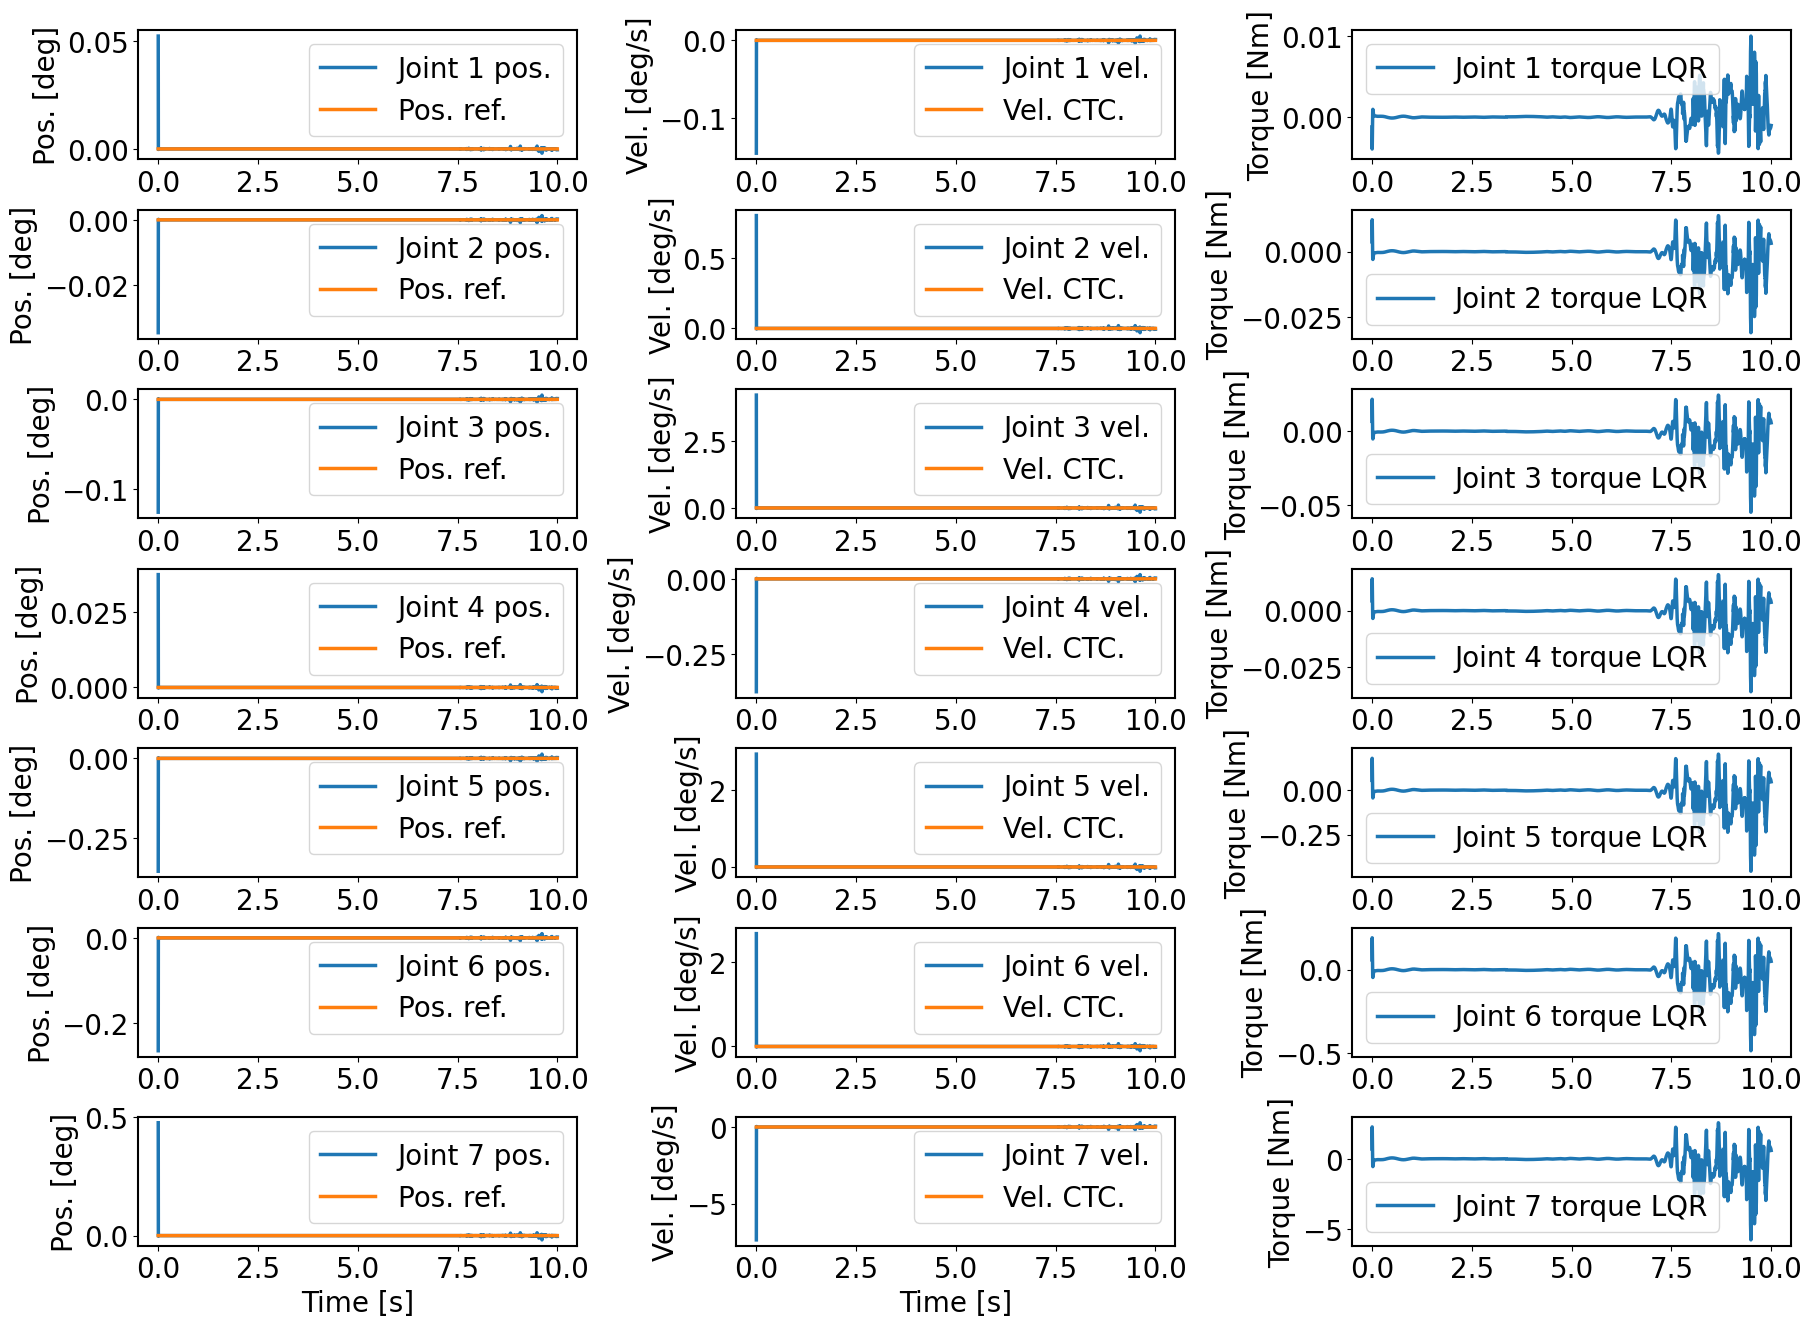

In [94]:
# Train linear model
traj = 0

n = 15
r = 1
d = 7
u_std = 0.0

model = HAVOK(delta_X[traj,:,:-1], delta_U[traj,:,:])
model.HANKEL(n, d)
model.SVD(r)
model.LS(r,rcond=0)

# Train LQR controller
model.ConstructLQR(x_std=np.concatenate((1e6*np.ones([7]),np.zeros([7]))),
                   u_std=u_std,
                   dt=dt,
                   ref=ref_zeros,
                   disturbance=delta_U[traj,:,:].numpy()) # To learn on differences
#                    disturbance=pandaRobot2.U[traj,:,:].numpy())
model.LQR_simulate(X0=pandaRobot.ref[traj,:,0],disturbance=delta_U[traj,:,:].numpy())

loss_LQR_subspace = model.RMSE(X_pred=torch.tensor(model.LQR_X[:7,:]),
                               X_true=torch.tensor(ref_zeros[:7,:]),
                               regulation=True)
print('LQR RMSE : '+str(loss_LQR_subspace))

# plt.rcParams['font.size'] = 20
# fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize=(18,8))

# figA = snb.heatmap(model.A,cmap='Reds',ax=ax[0])
# figB = snb.heatmap(model.B,cmap='Reds',ax=ax[1])

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,13))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T[:-1], rad2deg(model.LQR_X[i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T[:-1], rad2deg(ref_zeros[i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T[:-1], rad2deg(model.LQR_X[7+i,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T[:-1], rad2deg(ref_zeros[7+i,:]), label='Vel. CTC.')
    ax[i,2].plot(pandaRobot.T[:-2], model.LQR_U[0,:,i], label='Joint '+str(i+1)+' torque LQR')
#     ax[i,2].plot(pandaRobot.T[:-1], pandaRobot.U[traj,i,:], label='Joint '+str(i+1)+' torque CTC')
    ax[i,0].set_ylabel('Pos. [deg]'), ax[i,1].set_ylabel('Vel. [deg/s]'), ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

### Apply LQR planner onto real robot dynamics

C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


joints are free now
LQR RMSE : 497.4645270185171


(Text(0.5, 0, 'Time [s]'), Text(0.5, 0, 'Time [s]'))

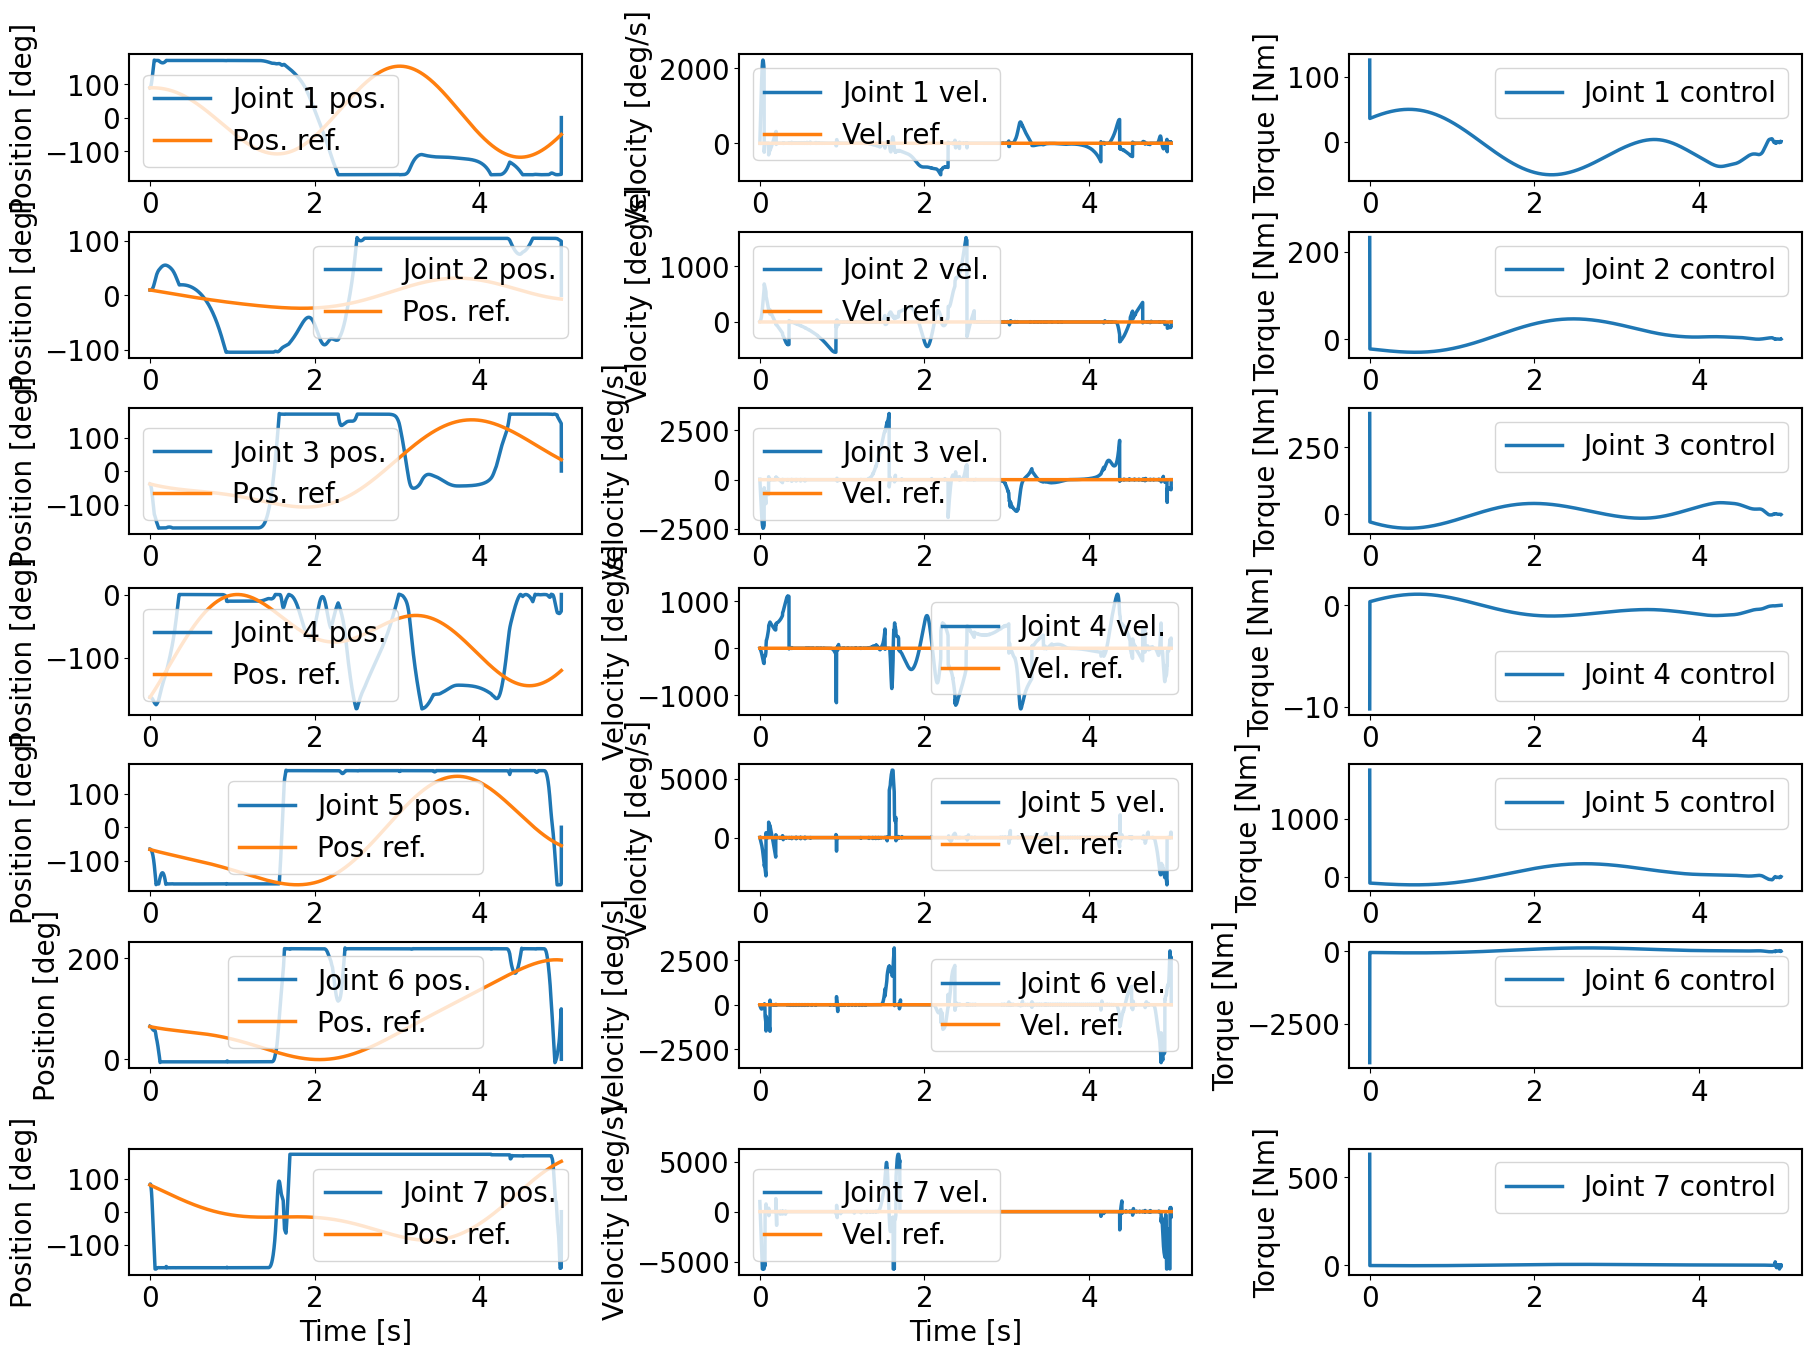

In [23]:
X0 = pandaRobot.ref[traj,:,0]
Xc, Yc = np.zeros(shape=[model.nb_S,model.N]), np.zeros(shape=[model.tau,model.N])
Uc = np.empty(shape=[model.nb_U,model.N-1])

# Initial condition
Xc[:,0] = X0
# N = np.eye(model.tau) - pinv(model.C) @ model.C
Y0 = pinv(model.C)@X0
# Y0 = Y0 + N@(model.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

robot.default_q = Xc[:7,0]
robot.reset_q(max_iter=100)
robot.joints_free=True

sum_error = np.zeros(7)

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model.N-1):
    error_q = pandaRobot.ref[traj,:7,i] - robot.q
    error_dq = pandaRobot.ref[traj,7:,i] - robot.dq

#   Computed Torque Control
    control_input = configuration_ctc(Kp @ error_q + Ki @ sum_error + Kd @ error_dq + pandaRobot.desired_ddq[traj,:,i],
                                     robot, P=P)
#     PID Control + Feedforward term 
#         control_input = robot.inverse_dynamics(pandaRobot.desired_ddq[n,:,i]) + Kp @ error_q + Ki @ sum_error + Kd @ error_dq
#         control_input = Kp @ error_q + Ki @ sum_error + Kd @ error_dq

    for j in range(7):
        if control_input[j] < robot.joint_torque_limits[j,0]:
            control_input[j] = robot.joint_torque_limits[j,0].copy()
        if control_input[j] > robot.joint_torque_limits[j,1]:
            control_input[j] = robot.joint_torque_limits[j,1].copy()

#   LQR planner control input
    control_input = model.LQR.get_command(Yc[:,i],i)

    robot.set_torque(control_input[:7])

    log_error.append(np.copy(error_q))
    Xc[0:7,i] = robot.q
    Xc[7:,i] = robot.dq
#     log_ddq[n,:,i] = robot.ddq
    Uc[:,i] = np.copy(control_input)
#     time.sleep(dt) # Real-time rendering
    sum_error += error_q*dt
    
    Yc[:,i+1] = pinv(model.C)@Xc[:,i+1]
    
loss_LQR_true = model.RMSE(X_pred=Xc[, 
                                    X_true=pandaRobot.ref[traj,:,:])
print('LQR RMSE : '+str(loss_LQR_true))
    
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(7, 3, constrained_layout = True, figsize=(18,13))

for i in range(7):
    
    ax[i,0].plot(pandaRobot.T, rad2deg(Xc[i,:]), label='Joint '+str(i+1)+' pos.')
    ax[i,0].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i,:]), label='Pos. ref.')
    ax[i,1].plot(pandaRobot.T, rad2deg(Xc[i+7,:]), label='Joint '+str(i+1)+' vel.')
    ax[i,1].plot(pandaRobot.T, rad2deg(pandaRobot.ref[traj,i+7,:]), label='Vel. ref.')
    ax[i,2].plot(pandaRobot.T[:len(pandaRobot.T)-1], Uc[i,:], label='Joint '+str(i+1)+' control')
    
    ax[i,0].set_ylabel('Position [deg]'), ax[i,1].set_ylabel('Velocity [deg/s]')
    ax[i,2].set_ylabel('Torque [Nm]')
    ax[i,0].legend(), ax[i,1].legend(), ax[i,2].legend()
    
ax[6,0].set_xlabel('Time [s]'), ax[6,1].set_xlabel('Time [s]')

In [44]:
print(Xc[:,0],pandaRobot.ref[traj,:,0])

[ 1.92311 -0.84735  1.12334 -1.5787   1.15286 -0.00617 -1.87547  0.32676
 -0.18946 -0.40925 -0.64609  0.71115 -0.24451 -1.27567] [-1.00575 -0.67185  1.75852 -0.44156 -1.78396  1.44367  0.94552  0.
  0.       0.       0.       0.       0.       0.     ]
